In [1]:
import numpy as  np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.spatial.distance import cdist 
from scipy.special import kv, gamma

from sklearn.metrics import root_mean_squared_error
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split

import time

import warnings
warnings.filterwarnings('ignore')

In [2]:
matern_model = lambda t, nu: np.vectorize(lambda x: 2**(1-nu) / gamma(nu) * (t*x)**nu * kv(nu, t*x))

def cov_matrix(cov_model, X_1, X_2, rho=1):
    return rho * np.nan_to_num(cov_model(cdist(X_1,X_2)), nan=1)

def k(x, X_1, X_2, cov_1, cov_12, rho_12):
    return np.concatenate([cov_matrix(cov_1, X_1, x), cov_matrix(cov_12, X_2, x, rho_12)])

def K(X_1, X_2, cov_1, cov_2, cov_12, rho_12):
    return np.block([[cov_matrix(cov_1, X_1, X_1), cov_matrix(cov_12, X_1, X_2, rho_12)], 
                     [cov_matrix(cov_12, X_2, X_1, rho_12), cov_matrix(cov_2, X_2, X_2)]])

In [3]:
def gen_observations(d, n_1, n_2, sup, nu_1, theta_1, nu_2, theta_2, nu_12, theta_12, rho_12):
    X_1 = np.random.uniform(0, sup, (n_1, d))
    X_2 = np.random.uniform(0, sup, (n_2, d))
    
    sigma = K(X_1, X_2, matern_model(theta_1, nu_1), matern_model(theta_2, nu_2), matern_model(theta_12, nu_12), rho_12)
    Y = np.linalg.cholesky(sigma) @ np.random.normal(0, 1, (n_1+n_2))

    return X_1, X_2, Y[:n_1], Y[n_1:] # (X_1, X_2, Y_1, Y_2)

def gen_A(X, n_clusters):
    KM = KMeans(n_clusters=n_clusters).fit(X)
    A = [[] for _ in range(n_clusters)]
    for i, label in enumerate(KM.labels_):
        A[label].append(i)
    return A

In [4]:
def check_consistent_dimension(d, *arrays):
    """Check whether all arrays have consistent dimensions along a specified axis.

    This function verifies if all arrays have the same shape or length along a specific dimension.

    Parameters
    ----------
    d : int
        The dimension along which consistency will be checked.
        For example, use d=0 to ensure the same number of observations,
        and d=1 to ensure the same length of observations.
    *arrays : list or tuple of input objects
        Objects that will be checked for consistent dimensions.

    Raises
    ------
    ValueError
        If input variables have inconsistent dimensions along the specified axis.
    """

    dimensions = [(X.shape[d] if d>0 else len(X)) for X in arrays if X is not None]
    if len(np.unique(dimensions)) > 1:
        raise ValueError(
            "Found input variables with inconsistent numbers of dimensions: %r"
            % [int(l) for l in dimensions]
        )
        
        
def check_positive_elements(*args):
    """Check whether all elements in the provided arguments are greater than 0.

    Parameters
    ----------
    *args : int or float
        Values to be checked for positivity.

    Raises
    ------
    ValueError
        If any provided value is not greater than 0.
    """
    for arg in args:
        if arg <= 0:
            raise ValueError("Found a non-positive parameter.")


In [5]:
class NestedCoKriging:
    '''
    Queremos predecir observaciones de la variable Y_1 utilizando las obs. de ambas.
    '''
    def __init__(self, X_1, X_2, Y_1, Y_2, theta_1, theta_2, theta_12, nu_1, nu_2, nu_12, rho_12):
        check_consistent_dimension(1, X_1, X_2)
        check_consistent_dimension(0, X_1, Y_1)
        check_consistent_dimension(0, X_2, Y_2)
        self.X_1, self.X_2 = X_1, X_2
        self.Y_1, self.Y_2 = Y_1, Y_2
        self.d = self.X_1.shape[1]
        self.n_1, self.n_2 = self.X_1.shape[0], self.X_2.shape[0]
        
        check_positive_elements(theta_1, theta_2, theta_12, nu_1, nu_2, nu_12)
        self.theta_1 = theta_1
        self.theta_2 = theta_2
        self.theta_12 = theta_12
        self.nu_1 = nu_1
        self.nu_2 = nu_2
        self.nu_12 = nu_12
        self.rho_12 = rho_12
        
        
        self.sigma = None
        self.sigma_12 = None # cov(Y_1, Y_2)   n_1 x n_2
         
        self.ZZZ = None
        
    def ncok(self, x, A_1, A_2):
        check_consistent_dimension(0, A_1, A_2)
        if self.sigma is None:
            self.sigma_12 = cov_matrix(matern_model(self.theta_12, self.nu_12), self.X_1, self.X_2, self.rho_12)
            self.sigma = np.block([[cov_matrix(matern_model(self.theta_1, self.nu_1), self.X_1, self.X_1), self.sigma_12], 
                                   [self.sigma_12.T, cov_matrix(matern_model(self.theta_2, self.nu_2), self.X_2, self.X_2)]])
                    
        Y = np.concatenate([self.Y_1, self.Y_2])
        A = [[x,y] for x,y in zip(A_1, A_2)]
        shift_n = self.n_1
        k_x_Xs = k(x, self.X_1, self.X_2, matern_model(self.theta_1, self.nu_1), matern_model(self.theta_12, self.nu_12), self.rho_12)
        
        
        lens_A = [sum(len(subsublist) for subsublist in sublist) for sublist in A]
        cumsum_lens_A = np.cumsum(lens_A)
        
        if self.ZZZ is None:
            self.gen_big_matrix(A, shift_n, lens_A, cumsum_lens_A)
        
        pivot, C = 0, np.zeros((sum(lens_A), len(A)))
    
        M = np.zeros((len(A), 1))
        
        for i in range(len(A)):
            indexes = A[i][0]+list(shift_n+np.array(A[i][1]))
            
            C[pivot:(pivot+lens_A[i]), [i]] = np.linalg.solve(self.sigma[indexes, :][:, indexes], k_x_Xs[indexes, :])
            
            M[i] = C[pivot:(pivot+lens_A[i]), [i]].T @ Y[indexes]
            
            pivot+=lens_A[i]
            
        # cov(M, M) = C.T @ ZZZ @ C
        # cov(M, Y) = diag(C.T @ ZZZ @ C)
        
        K_M = C.T @ self.ZZZ @ C
        return np.diag(K_M) @ np.linalg.solve(K_M, M)
    
    def gen_big_matrix(self, A, shift_n, lens_A, cumsum_lens_A):
        row, self.ZZZ = 0, np.zeros((sum(lens_A), sum(lens_A)))
        for i in range(len(A)):
            column=cumsum_lens_A[i]
            for j in range(i+1, len(A)):
                indexes_i = A[i][0]+list(shift_n+np.array(A[i][1]))
                indexes_j = A[j][0]+list(shift_n+np.array(A[j][1]))
                self.ZZZ[row:(row+lens_A[i]), column:(column+lens_A[j])] = self.sigma[indexes_i, :][:, indexes_j]
                column+=lens_A[j]
            row+=lens_A[i]
        self.ZZZ += self.ZZZ.T
        pivot = 0
        for i in range(len(A)):
            indexes = A[i][0]+list(shift_n+np.array(A[i][1]))
            self.ZZZ[pivot:(pivot+lens_A[i]), pivot:(pivot+lens_A[i])] = self.sigma[indexes, :][:, indexes]
            pivot+=lens_A[i]
    
    def predict(self, X_test, A_1, A_2):
        check_consistent_dimension(0, A_1, A_2)
        return np.array([self.ncok(X_test[[i]], A_1, A_2) for i in range(len(X_test))])
    
    def plot_obs(self, figsize=(12, 5)):
        if self.d != 2:
            raise ValueError('La dimensión de los sitios debe ser 2.')
        
        fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=figsize)
        ax1.scatter(self.X_1[:, 0], self.X_1[:, 1], c=self.Y_1)
        ax1.set_title(r'$Y_1$')
        scatter2 = ax2.scatter(self.X_2[:, 0], self.X_2[:, 1], c=self.Y_2)
        ax2.set_title(r'$Y_2$')
        fig.tight_layout()
        fig.colorbar(scatter2, ax=[ax1, ax2])

In [6]:
def kriging(x, X, Y, sigma, cov):
    '''
    x : prediction point
    X : the vector of observation points
    Y : observations
    sigma : covariance matrix of observations
    cov : covariance function cov(h) 
    '''
    return cov_matrix(cov, x, X) @ np.linalg.solve(sigma, Y)

class NestedKriging:
    '''
    Implements Nested Kriging for predicting outputs based on observations.

    This class provides functionality for predicting outputs using Nested Kriging,
    a method described in the paper "Nested Kriging predictions for datasets with a 
    large number of observations" by Rullière et al. (2018).

    Parameters
    ----------
    X : array-like
        Vector of all observation points.
    Y : array-like
        All observations.
    cov : function
        Isotropic covariance function. C: h -> C(h) 
    theta : float
        Scale parameter for the Matérn covariance model.
    nu : float
        Smoothness parameter for the Matérn covariance model.

    Attributes
    ----------
    X : array-like
        Vector of all observation points.
    Y : array-like
        All observations.
    theta : float or None
        Scale parameter for the Matérn covariance model.
    nu : float or None
        Smoothness parameter for the Matérn covariance model.
    cov : function or None
        Isotropic covariance function. C: h -> C(h) 
    sigma : array-like or None
        Covariance matrix of the observation points.
    ZZZ : array-like or None
        Large matrix used in nested kriging predictions.

    Methods
    -------
    nk(x, A)
        Predicts the output at a given prediction point using nested kriging.
    predict(X_test, A)
        Predicts the output for the given prediction points using nested kriging.
    gen_big_matrix(A, lens_A, cumsum_lens_A)
        Generates a large matrix for nested kriging predictions.
    '''
    def __init__(self, X, Y, cov=None, theta=None, nu=None):
        if len(X) != len(Y):
            raise ValueError(
            "Found input variables with inconsistent numbers of dimensions: %r"
            % [len(X), len(Y)]
            )        
        if theta is not None and nu is not None:
            if theta <= 0 or nu <= 0:
                raise ValueError("Found a non-positive parameter.")
        self.X = X
        self.Y = Y
        self.theta = theta
        self.nu = nu
        
        self.cov = matern_model(self.theta, self.nu) if cov is None else cov 
        
        self.sigma = None
        self.ZZZ = None
            
    def nk(self, x, A):
        '''
        Predicts the output at a given prediction point using nested kriging.

        This method implements nested kriging as described in the paper:
        "Nested Kriging predictions for datasets with a large number of observations"
        by Rullière et al. (2018).

        Parameters
        ----------
        x : array-like
            Prediction point.
        A : list of lists
            List of lists containing submodel indexes.

        Returns
        -------
        array
            Predicted output at the given prediction point using nested kriging.
        '''
        
        if self.sigma is None:
            self.sigma = cov_matrix(self.cov, self.X, self.X)
        
        k_x_X = cov_matrix(self.cov, self.X, x)    
        lens_A = [len(sublist) for sublist in A]
        cumsum_lens_A = np.cumsum(lens_A)
        
        if self.ZZZ is None:
            self.gen_big_matrix(A, lens_A, cumsum_lens_A)
        
        pivot, C = 0, np.zeros((sum(lens_A), len(A)))
        M = np.zeros((len(A), 1))
        
        for i in range(len(A)):
            C[pivot:(pivot+lens_A[i]), [i]] = np.linalg.solve(self.sigma[A[i], :][:, A[i]], k_x_X[A[i], :])
            M[i] = C[pivot:(pivot+lens_A[i]), [i]].T @ self.Y[A[i]]
            pivot+=lens_A[i]
            
        # cov(M, M) = C.T @ ZZZ @ C
        # cov(M, Y) = diag(C.T @ ZZZ @ C)
        
        K_M = C.T @ self.ZZZ @ C
        return np.diag(K_M) @ np.linalg.solve(K_M, M)
    
    def predict(self, X_test, A):
        '''
        Predicts the output for the given prediction points.

        Parameters
        ----------
        X_test : array-like
            Array containing prediction points.
        A : list of list
            List of lists containing submodel indexes.

        Returns
        -------
        array
            Array containing the predicted outputs for the given prediction points.
        '''
        return np.array([self.nk(X_test[[i]], A) for i in range(len(X_test))])
    
    def gen_big_matrix(self, A, lens_A, cumsum_lens_A):
        '''
        Generates a large matrix for nested kriging predictions.

        This method constructs a large matrix used in nested kriging predictions, 
        composed of blocks of the form cov(X_i, X_j), where X_i represents the points 
        considered in submodel i.

        Parameters
        ----------
        A : list of lists
            List of lists containing submodel indexes.
        lens_A : list
            List containing the lengths of submodel indexes.
        cumsum_lens_A : array-like
            Cumulative sum of lengths of submodel indexes.

        Returns
        -------
        None
        '''
        row, self.ZZZ = 0, np.zeros((sum(lens_A), sum(lens_A)))
        for i in range(len(A)):
            column=cumsum_lens_A[i]
            for j in range(i+1, len(A)):
                self.ZZZ[row:(row+lens_A[i]), column:(column+lens_A[j])] = self.sigma[A[i], :][:, A[j]]
                column+=lens_A[j]
            row+=lens_A[i]
        self.ZZZ += self.ZZZ.T
        pivot = 0
        for i in range(len(A)):
            self.ZZZ[pivot:(pivot+lens_A[i]), pivot:(pivot+lens_A[i])] = self.sigma[A[i], :][:, A[i]]
            pivot+=lens_A[i]
    
def k_coK(x, X_1, X_2, cov_1, cov_2, cov_12, rho_12):
    return np.block([[cov_matrix(cov_1, x, X_1), cov_matrix(cov_12, x, X_2, rho_12)], 
                     [cov_matrix(cov_12, x, X_1, rho_12), cov_matrix(cov_2, x, X_2)]])    

def co_kriging(x, X_1, X_2, Y_1, Y_2, cov_1, cov_2, cov_12, rho_12, sigma):
    'si x es un conjunto de puntos, entrega las predicciones (Y_1.T, Y_2.T).T'
    c = k(x, X_1, X_2, cov_1, cov_12, rho_12)    
    return c.T @ np.linalg.solve(sigma, np.concatenate([Y_1, Y_2]))

In [7]:
def scatterplot(X,Y,title='',xlabel='',ylabel=''):
    plt.scatter(X.reshape(-1), Y.reshape(-1))
    plt.plot([min(min(X), min(Y)), max(max(X), max(Y))], [min(min(X), min(Y)), max(max(X), max(Y))], ls = '--', lw = 2, c = 'r')
    plt.title(title); plt.xlabel(xlabel); plt.ylabel(ylabel)

Parámetros

In [8]:
d = 2

n_1 = 2_000
n_2 = 3_000

sup = 20

# Parameters
nu_1 = 3/2
theta_1 = 1

nu_2 = 1/2
theta_2 = 1

nu_12 = ( nu_1 + nu_2 ) / 2
theta_12 = min(theta_1, theta_2)
rho_12 = (theta_12**2/(theta_1*theta_2))**(d/2) * ( gamma(nu_1+d/2)*gamma(nu_2+d/2) / (gamma(nu_1)*gamma(nu_2)) )**(1/2) * gamma(nu_12)/gamma(nu_12+d/2)
rho_12

0.8660254037844387

In [9]:
X_1, X_2, Y_1, Y_2 = gen_observations(d, n_1, n_2, sup, nu_1, theta_1, nu_2, theta_2, nu_12, theta_12, rho_12)

In [10]:
X_1, X_test, Y_1, Y_test = train_test_split(X_1, Y_1, test_size=0.25)

In [11]:
X_1.shape, X_test.shape

((1500, 2), (500, 2))

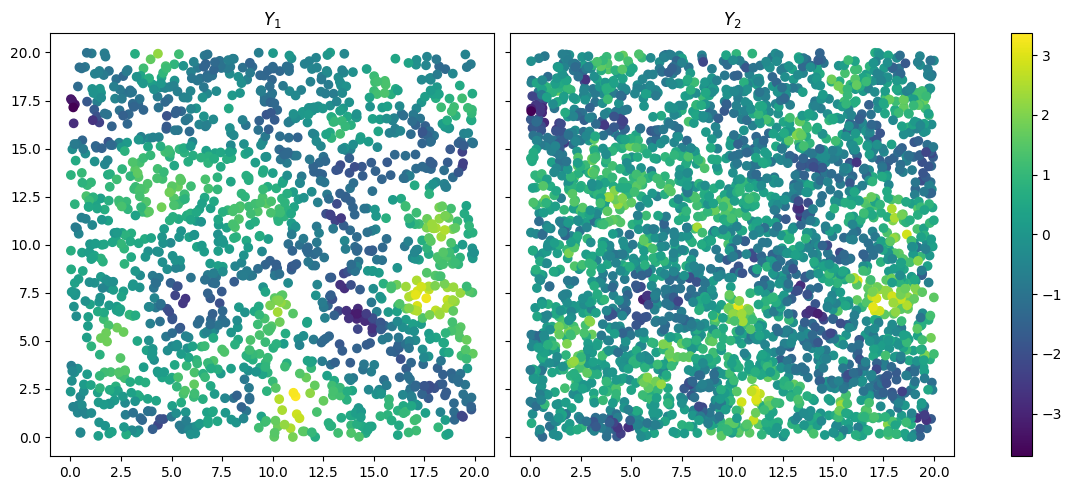

In [12]:
NestedCoKriging(X_1, X_2, Y_1, Y_2, theta_1, theta_2, theta_12, nu_1, nu_2, nu_12, rho_12).plot_obs()

## Análisis `n_clusters`

In [22]:
times = []
rmses = []
iter_n_clusters = np.array([2, 4, 8, 16, 32, 64, 128, 256, 512])
num_iterations = 10

for n_clusters in iter_n_clusters:
    execution_time = 0
    rmse = 0
    for _ in range(num_iterations):
        start_time = time.time()
        
        A_1 = gen_A(X_1, n_clusters)
        A_2 = gen_A(X_2, n_clusters)
        NcoK = NestedCoKriging(X_1, X_2, Y_1, Y_2, theta_1, theta_2, theta_12, nu_1, nu_2, nu_12, rho_12)
        Y_NcoK = NcoK.predict(X_test, A_1, A_2)
        
        end_time = time.time()
        
        execution_time += end_time - start_time
        rmse += root_mean_squared_error(Y_NcoK, Y_test)
    
    times.append(execution_time / num_iterations)
    rmses.append(rmse / num_iterations)

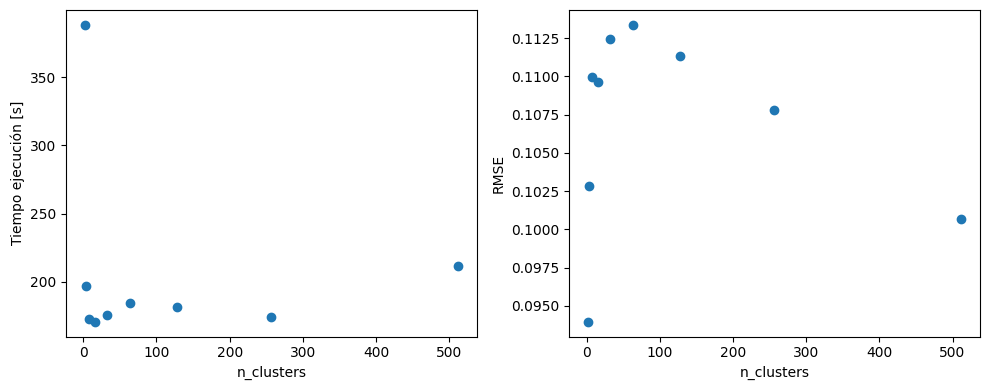

In [23]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,4))

ax1.scatter(iter_n_clusters, times)
ax1.set_xlabel('n_clusters'); ax1.set_ylabel('Tiempo ejecución [s]')

ax2.scatter(iter_n_clusters, rmses)
ax2.set_xlabel('n_clusters'); ax2.set_ylabel('RMSE')

fig.tight_layout()

#OBS PROM POR CLUSTER = TOTAL_OBS / #CLUSTERS

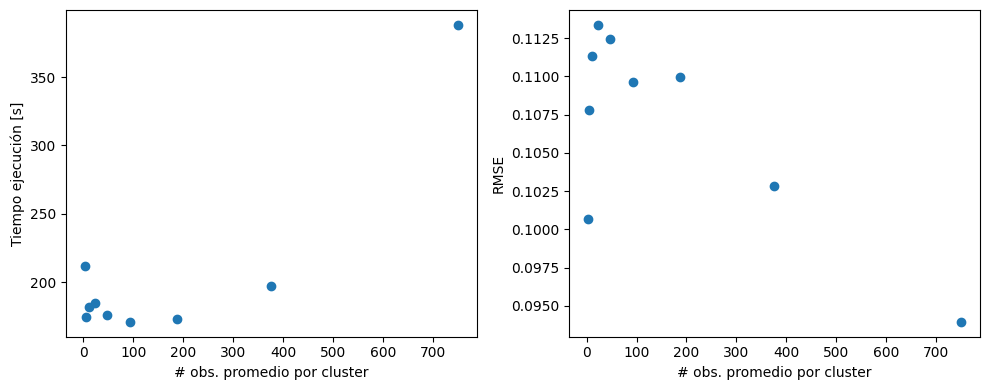

In [24]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,4))

ax1.scatter(X_1.shape[0] / np.array(iter_n_clusters), times)
ax1.set_xlabel('# obs. promedio por cluster'); ax1.set_ylabel('Tiempo ejecución [s]')

ax2.scatter(X_1.shape[0] / np.array(iter_n_clusters), rmses)
ax2.set_xlabel('# obs. promedio por cluster'); ax2.set_ylabel('RMSE')

fig.tight_layout()

## Comparamos los 4 métodos

In [35]:
n_clusters = 250

In [36]:
start_time = time.time()

A_1 = gen_A(X_1, n_clusters)
A_2 = gen_A(X_2, n_clusters)
NcoK = NestedCoKriging(X_1, X_2, Y_1, Y_2, theta_1, theta_2, theta_12, nu_1, nu_2, nu_12, rho_12)
Y_NcoK = NcoK.predict(X_test, A_1, A_2)

end_time = time.time()
time_NcoK = end_time - start_time

In [37]:
start_time = time.time()

sigma = cov_matrix(matern_model(theta_1, nu_1), X_1, X_1)
Y_K = kriging(X_test, X_1, Y_1, sigma, matern_model(theta_1, nu_1))

end_time = time.time()
time_K = end_time - start_time

In [38]:
start_time = time.time()

sigma = K(X_1, X_2, matern_model(theta_1, nu_1), matern_model(theta_2, nu_2), matern_model(theta_12, nu_12), rho_12)
Y_coK = co_kriging(X_test, X_1, X_2, Y_1, Y_2, matern_model(theta_1, nu_1), matern_model(theta_2, nu_2), matern_model(theta_12, nu_12), rho_12, sigma)

end_time = time.time()
time_coK = end_time - start_time

In [39]:
start_time = time.time()

NK = NestedKriging(X_1, Y_1, theta=theta_1, nu=nu_1)
Y_NK = NK.predict(X_test, A_1)

end_time = time.time()
time_NK = end_time - start_time

In [40]:
RMSE_K = root_mean_squared_error(Y_K, Y_test)
RMSE_NK = root_mean_squared_error(Y_NK, Y_test)
RMSE_coK = root_mean_squared_error(Y_coK, Y_test)
RMSE_NcoK = root_mean_squared_error(Y_NcoK, Y_test)

In [41]:
RMSE_coK < RMSE_NcoK < RMSE_K < RMSE_NK

True

In [42]:
RMSE_coK, RMSE_NcoK, RMSE_K, RMSE_NK

(0.08350944822827279,
 0.11008184275822966,
 0.12797912952594948,
 0.13968269645634235)

In [43]:
time_K < time_NK < time_coK < time_NcoK

True

In [44]:
time_K, time_NK, time_coK, time_NcoK

(30.979496955871582, 49.83596086502075, 145.76787114143372, 593.4517714977264)

## Análisis de RMSE vs $\rho_{12}$

In [47]:
# Parameters fixed
d = 2
n_1 = 300
n_2 = 500
sup = 20

nu_1 = 3/2
theta_1 = 1
nu_2 = 3/2
nu_12 = ( nu_1 + nu_2 ) / 2

In [57]:
rhos_12 = []
RMSEs_K = []
RMSEs_NK = []
RMSEs_coK = []
RMSEs_NcoK = []

thetas_2 = np.arange(0.05, 1.05, 0.05)
num_iterations = 20

for theta_2 in thetas_2:
    theta_12 = min(theta_1, theta_2)
    rho_12 = (theta_12**2/(theta_1*theta_2))**(d/2) * ( gamma(nu_1+d/2)*gamma(nu_2+d/2) / (gamma(nu_1)*gamma(nu_2)) )**(1/2) * gamma(nu_12)/gamma(nu_12+d/2)
    rhos_12.append(rho_12)
    
    RMSE_K = 0
    RMSE_NK = 0
    RMSE_coK = 0
    RMSE_NcoK = 0
    
    for _ in range(num_iterations):
        X_1, X_2, Y_1, Y_2 = gen_observations(d, n_1, n_2, sup, nu_1, theta_1, nu_2, theta_2, nu_12, theta_12, rho_12)
        X_1, X_test, Y_1, Y_test = train_test_split(X_1, Y_1, test_size=0.33)

        # Nested CoKriging
        n_clusters = X_1.shape[0] // 2       
        A_1 = gen_A(X_1, n_clusters)
        A_2 = gen_A(X_2, n_clusters)
        NcoK = NestedCoKriging(X_1, X_2, Y_1, Y_2, theta_1, theta_2, theta_12, nu_1, nu_2, nu_12, rho_12)
        Y_NcoK = NcoK.predict(X_test, A_1, A_2)
        RMSE_NcoK += root_mean_squared_error(Y_NcoK, Y_test)
    
        
        # Kriging
        sigma = cov_matrix(matern_model(theta_1, nu_1), X_1, X_1)
        Y_K = kriging(X_test, X_1, Y_1, sigma, matern_model(theta_1, nu_1))
        RMSE_K += root_mean_squared_error(Y_K, Y_test)
        
        # Nested Kriging
        NK = NestedKriging(X_1, Y_1, theta=theta_1, nu=nu_1)
        Y_NK = NK.predict(X_test, A_1)
        RMSE_NK += root_mean_squared_error(Y_NK, Y_test)
            
        # CoKriging     
        sigma = K(X_1, X_2, matern_model(theta_1, nu_1), matern_model(theta_2, nu_2), matern_model(theta_12, nu_12), rho_12)
        Y_coK = co_kriging(X_test, X_1, X_2, Y_1, Y_2, matern_model(theta_1, nu_1), matern_model(theta_2, nu_2), matern_model(theta_12, nu_12), rho_12, sigma)
        RMSE_coK += root_mean_squared_error(Y_coK, Y_test)
            
    RMSEs_NcoK.append(RMSE_NcoK / num_iterations)
    RMSEs_K.append(RMSE_K / num_iterations)
    RMSEs_NK.append(RMSE_NK / num_iterations)
    RMSEs_coK.append(RMSE_coK / num_iterations)

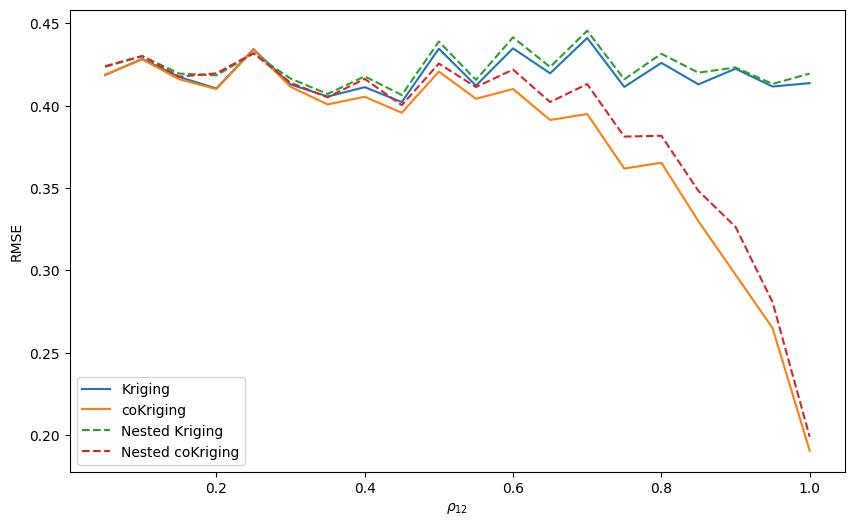

In [58]:
plt.figure(figsize=(10, 6))

plt.plot(rhos_12, RMSEs_K, label='Kriging')
plt.plot(rhos_12, RMSEs_coK, label='coKriging')
plt.plot(rhos_12, RMSEs_NK, label='Nested Kriging', ls='--')
plt.plot(rhos_12, RMSEs_NcoK, label='Nested coKriging', ls='--')
plt.legend()
plt.xlabel(r'$\rho_{12}$'); plt.ylabel('RMSE');

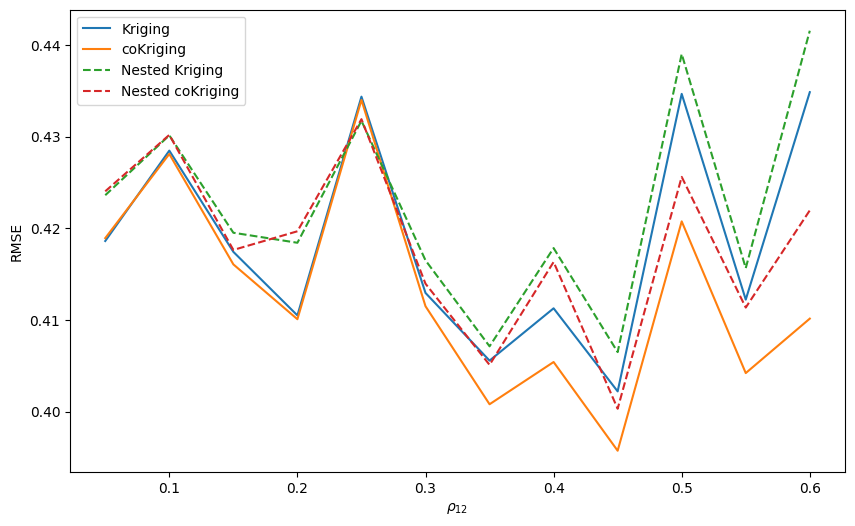

In [62]:
plt.figure(figsize=(10, 6))

plt.plot(rhos_12[:12], RMSEs_K[:12], label='Kriging')
plt.plot(rhos_12[:12], RMSEs_coK[:12], label='coKriging')
plt.plot(rhos_12[:12], RMSEs_NK[:12], label='Nested Kriging', ls='--')
plt.plot(rhos_12[:12], RMSEs_NcoK[:12], label='Nested coKriging', ls='--')
plt.legend()
plt.xlabel(r'$\rho_{12}$'); plt.ylabel('RMSE');